In [1]:
"""
This script is used to loop over a collection of .png spectrograph data from MISS-2 and detect continuum emission events.
In general, this script is based on two assumptions:
    1) The three auroral emission lines are distinct peaks in the column-wise mean spectrum when auroral events are observed in (relatively) clear skies
    2) Auroral continuum emission is observed as a spectral enhancement in the entire 400-700 nm wavelength range and hence can be registered as a 
        distinct peak in the row-wise mean spectrum.

NOTE:
- The scipy peak finding function parameters (prominence and width) are not optimized!!
- The current parameters are based on a comparison between known continuum, 'normal' aurora and clear sky events.
- Weak continuum events are possibly not detected. 
- The spectral resolution of MISS-2 is higher than MISS-1. Different values for the prominence and width are required!

Filtering out false positives, such as sunlit clouds, is done in the *** script.

The first defined function (read_MISS2) is rewritten to python from a MATLAB script by @MikkoS.

Created on May 9 2025

@author: Tim Hulsen
"""

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, medfilt2d

In [2]:
def read_MISS2(filename):

    """
    Reads MISS-2 .png spectrograph image.
    Use 2D meridian filtering to reduce noise. No compensation for a "smiley" figure is required, in contrast to MISS-1.

    Outputs a matrix with the vertical axis being a proxy for the scan angle (no calibration yet). The horizontal axis is wavelength from
    400nm to 700nm. The approximated wavelengths are added in the output.
    """
    
    im = plt.imread(filename)
    
    # Use 2D meridian filtering to filter out noise
    im = medfilt2d(im)
    im = np.fliplr(np.transpose(im))

    # Approximate wavelengths
    [n,m] = np.shape(im)
    x = np.linspace(1,m,m)
    wavelengths = (4054.2+2.6423*x+1.6716e-4*x**2)/10

    # Use data between rows 70 and 270
    spectralimage = im[70:270,:]

    return spectralimage, wavelengths

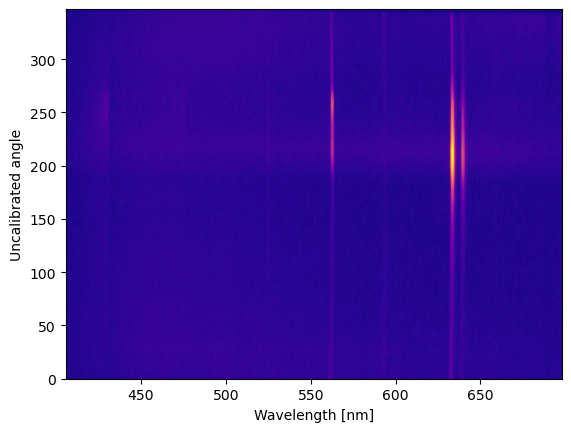

In [13]:
# Example of spectral image from MISS-2
filename = os.path.join('Example files','MISS2-20241222-092830.png')
spectralimage, w = read_MISS2(filename)

fig, ax = plt.subplots()
ax.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',
          extent=[min(w),max(w), 0, 347])
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Uncalibrated angle');

#fig.savefig("example spectral image MISS2",bbox_inches='tight')

In [4]:
def find_auroral_emission_lines(roi_data):
    
    """
    Input is the square root of a spectral image as plotted above.
    A range of rows can be excluded from the spectralimage. The remainder is the region of interest or roi.

    First calculates the mean of every column. 
    Identifies peaks with the scipy find_peaks function based on a minimum prominence and width.
    Checks whether the three auroral emission lines are detected. 

    Output Boolean value 'check'. True when the green AND red auroral emission line are detected.
    The Boolean value corresponding to the blue auroral emission line is returned independently.
    An example of continuum emission was discovered where the blue auroral emission line is too weak to detect.
    """
    
    # Calculate the column-wise mean within the ROI
    col_means = np.mean(roi_data, axis=0)

    # Use scipy.signal.find_peaks to identify peaks
    global_peaks_col, properties = find_peaks(
        col_means,
        prominence=0.02,  # Minimum prominence of peaks
        width=5          # Minimum width of peaks
    )
    
    # Check whether auroral emission lines are clear
    # Window of 10 columns centered around predicted emission line index, as calibration is off!!
    condition_aurora_blue = any(78 <= num <= 88 for num in global_peaks_col)     
    condition_aurora_green = any(550 <= num <= 560 for num in global_peaks_col) 
    condition_aurora_red = any(802 <= num <= 812 for num in global_peaks_col)     

    check = condition_aurora_green and condition_aurora_red
    
    return check, condition_aurora_blue

In [5]:
def find_continuum_line_save(roi_data, blue_condition, lower_limit, filename, file):   

    """
    Input again is the region of interest from the square root of a spectral image. 

    Calculates the mean of every row for the columns 550 to 820.
    This wavelength range is considered as the variance of a blue sky or sunlit cloud spectrum is less prominent in this range than at shorter 
    wavelengths (close to 460 nm), reducing the detection of false positives.
    
    Identifies peaks in the row-wise mean with the scipy find_peaks function based on a minimum prominence and width.

    The minimum prominence and width as well as the investigated wavelength range should be optimized in a statistical study!

    NOTE: 
    - The index of a detected peak is dependent on the input roi. 
    - Compensate the index with the lower limit of the roi for later analysis in the full spectral image (see example).
    - THE PROMINENCE OF PEAKS CHANGES WHEN A DIFFERENT ROI IS CHOSEN!!
    - It is advised to always use the same roi and optimize the parameters based on this roi!

    If at least one peak is detected this is saved in a notepad file.
    The first column includes the .png filename and the second column the peak indeces.
    """
    
    # Calculate the row-wise mean intensity within the ROI
    row_means = np.mean(roi_data[:,550:820], axis=1)

    # Use scipy.signal.find_peaks to identify peaks
    peaks, properties = find_peaks(
        row_means,
        prominence=0.02,  # Minimum prominence of peaks
        width=2          # Minimum width of peaks
    )

    # Adjust peak indices to global row indices
    global_peaks = peaks + lower_limit

    # Output the detected peaks
    if len(global_peaks) > 0:
        file.write(f"{filename}\t{global_peaks}\t{blue_condition}\n")

## Example of defined functions

In [6]:
# Use the spectral image shown for example previously
# For the roi the rows between 30 and 180 have been used to exclude the sun on the horizon
roi_data = np.sqrt(spectralimage)[30:180]

# Calculate the column-wise mean within the ROI
col_means = np.mean(roi_data, axis=0)

# Use scipy.signal.find_peaks to identify peaks
global_peaks_col, properties = find_peaks(
    col_means,
    prominence=0.02,  # Minimum prominence of peaks
    width=5          # Minimum width of peaks
)

# In the output it can be seen that only two auroral emission lines are detected. The blue emission line is not detected!
# An additional peak is detected at index 839
global_peaks_col

array([557, 809, 831], dtype=int64)

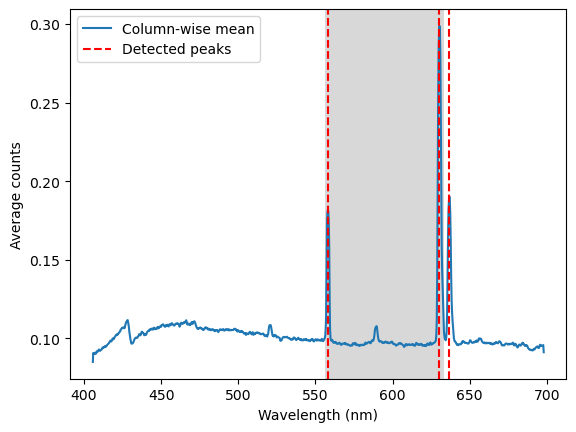

In [11]:
"""
Due to the higher resolution of MISS-2 compared to MISS-1 it is possible to detect two red auroral emission lines.
Both emission lines correspond to forbidden transitions of atomic oxygen.

Note that the blue auroral emission line is not detected. (spoiler alert) This is a big continuum event and one example of why the blue auroral emission
line is omitted from the condition that all auroral emission should be detected.

A bulge is visible in the spectrum around 460 nm. This is due to the blue sky in the image.
The gray shaded area is the wavelength range considered for detecting continuum emission.
"""

# Plot column-wise mean
plt.plot(w, col_means)

# Plot detected peaks
for peak in global_peaks_col:
    plt.axvline(x = w[peak], color='r', linestyle='dashed')

# The wavelength range considered for the detection of continuum emission
plt.axvspan(w[550], w[820], facecolor='gray', alpha=0.3)

plt.legend(("Column-wise mean", "Detected peaks"), loc=2)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Average counts");

In [9]:
# Now we want to detect continuum emission
# Continue with the same example

# Calculate the row-wise mean within the ROI
row_means = np.mean(roi_data[:,550:820], axis=1)

# Use scipy.signal.find_peaks to identify peaks
peaks, properties = find_peaks(
    row_means,
    prominence=0.02,  # Minimum prominence of peaks
    width=2          # Minimum width of peaks
)

# Since we used a ROI we should compensate the found indeces
lower_limit = 30

# Adjust peak indices to global row indices
global_peaks = peaks + lower_limit
global_peaks

array([76], dtype=int64)

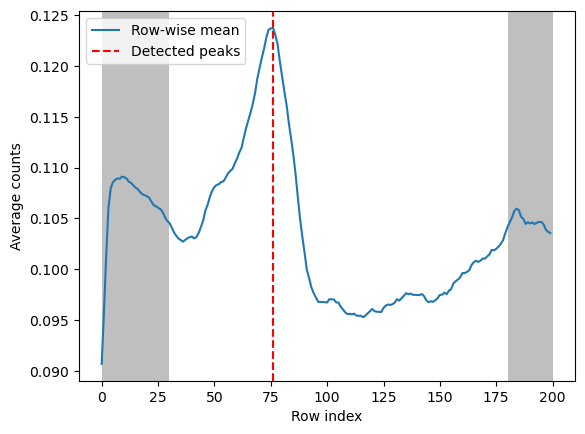

In [12]:
"""
It is visible in the gray shaded region that the number of counts drops off at the edges of the measurement.
This is an artifact of the measurement and is excluded as it can disrupt the peak finding function.
It is also possible that the sun is visible in these regions, resulting in a high number of counts which obscure the spectrum of auroras.
"""

# Plot row-wise mean of the ENTIRE spectral image
plt.plot(np.mean(np.sqrt(spectralimage), axis=1))

# Plot detected peaks
for peak in global_peaks:
    plt.axvline(x = peak, color='r', linestyle='dashed')

# Rows excluded in the ROI
plt.axvspan(0, 30, facecolor='gray', alpha=0.5)
plt.axvspan(180, 200, facecolor='gray', alpha=0.5)

plt.legend(("Row-wise mean", "Detected peaks"), loc=2)
plt.xlabel("Row index")
plt.ylabel("Average counts");

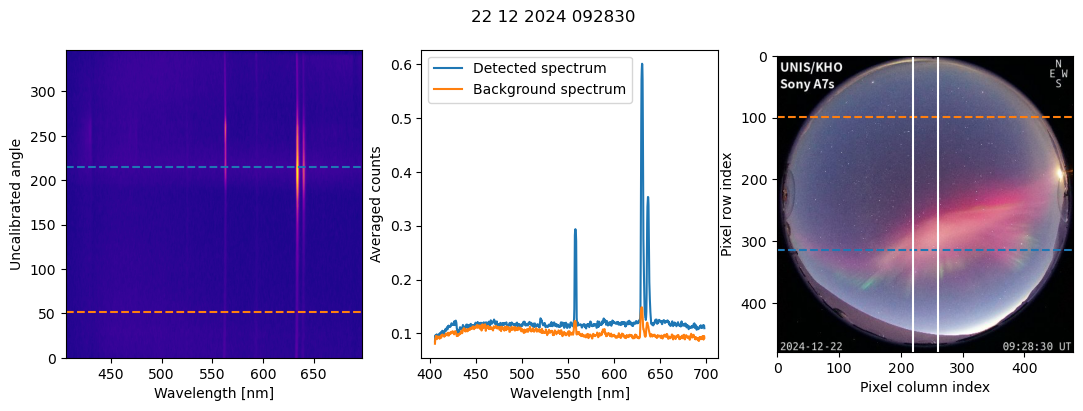

In [36]:
"""
This figure is a sneak peak of further analysis conducted in the *** script.
The blue dashed line in the spectral image highlights where the functions above have detected a peak in the row-wise mean.
In the middle plot the corresponding spectrum is shown, averaged over a few rows to reduce noise.
A background spectrum is added for comparison, which shows the spectral enhancement over the entire wavelength range that resulted in a peak in the 
row-wise mean.
From the Sony all-sky camera image it is clear that the detected spectrum corresponds to a region of white auroral continuum emission.
"""

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

# Plot the spectral image
ax1.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',extent=[min(w),max(w), 0, 347])
# Highlight the peak detected at index 76 with a blue dashed line
ax1.axhline(y=347-(347/200)*76, color='C0', linestyle='dashed')
# Highlight the peak at index 170 with a orange dashed line
# This row is chosen as the background spectrum, ideally this consists of a clear sky
ax1.axhline(y=347-(347/200)*170, color='C1', linestyle='dashed')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Uncalibrated angle')

# To reduce noise we average a range of rows to produce the emission spectra for the detected row and the background
# The spectra are plotted in blue and orange, respectively
ax2.plot(w, np.mean(np.sqrt(spectralimage)[74:79,:],axis=0), color='C0')
ax2.plot(w, np.mean(np.sqrt(spectralimage)[168:173,:],axis=0), color='C1')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Averaged counts')
ax2.legend(("Detected spectrum","Background spectrum"))

# Plot an image of the Sony all-sky camera closest to the moment the spectral image was taken
image = plt.imread(os.path.join('Example files','LYR-Sony-20241222_092830.jpg'))
ax3.imshow(image)
# Highlight where the 'interesting' spectrum was detected and the background spectrum is taken with dashed lines in their respective colors
ax3.axhline(y = 480-((480-20)/200)*76+10, color = 'C0', linestyle = 'dashed')
ax3.axhline(y = 480-((480-20)/200)*170+10, color = 'C1', linestyle = 'dashed')
ax3.set_xlabel('Pixel column index')
ax3.set_ylabel('Pixel row index')

# In the center between the white lines is the meridian of the spectrograph where the spectral image is taken
ax3.axvline(x = 480/2-20, color = 'white')
ax3.axvline(x = 480/2+20, color = 'white')

fig.suptitle("22 12 2024 092830");

## Applying this script to a dataset

In [ ]:
"""
An example of a loop used to go over the MISS-2 data from the KHO observatory.

The MISS-2 data is sorted in subfolders based on year, month and day. 
MISS-2 has a time resolution of 10 seconds, hence .png files have a YYYYMMDD-HHMMSS format in the filename (for example MISS2-20241222-092830.png).
As there is a .png file for every 10 seconds this can quickly result in a lot of data. 
The loop can easily be modified to go only over a single day, a single month or (if you like to hurt your trusted laptop) all years of data.

In the current loop there is an output text file for each day of MISS-2 data, where the .png filename, row indeces of detected peaks and the Boolean 
value corresponding to whether the blue auroral emission line is detected are stored.

NOTE 
- This output method was chosen to store the data locally such that this script only has to be run a single time, as it can take days to go over all 
    MISS-2 data!
- The auroral emission line detection function is run first and skips the file if the green and red emission lines are not detected to reduce 
    computation time.
"""

# Define the region of interest
lower_limit = 30  # Ignore rows below this
upper_limit = 180  # Ignore rows above this

year = ****
for month in os.listdir(os.path.join(your_data_directory,'MISS-2',year)):

    # The folders of each day can include png files that are incorrectly picked up by os.listdir as folders with data
    # Use os.scandir to only find folders
    folders = [f.name for f in os.scandir(os.path.join(your_data_directory,'MISS-2',year,month)) if f.is_dir()]
    for day in folders:

        # Create output text file for every day
        output_file = f"your_output_directory\\{year}\\{month}\\MISS2_{year}_{month}_{day}.txt"
        with open(output_file, "a") as file: # 'a' mode appends instead of overwriting
    
            for filename in os.listdir(os.path.join(your_data_directory,'MISS-2',year,month,day)):
                missFile=os.path.join(your_data_directory,'MISS-2',year,month,day,filename)
    
                try:
                    spectralimage= read_MISS2(missFile)[0]
    
                    # Restrict analysis to the region of interest
                    roi_data = np.sqrt(spectralimage)[lower_limit:upper_limit, :]

                    # Only proceed with the further analysis if green and red auroral emission lines are detected
                    # Reduces computation time
                    aurora_detected_condition, blue_condition = find_auroral_emission_lines(roi_data)
                    if aurora_detected_condition:
                        pass
                    else:
                        continue   
                    find_continuum_line_save(roi_data, blue_condition, lower_limit, filename, file)
                # Sometimes a .png file can be corrupted and abort the enire loop, this prevents that
                # The filename is printed for possible manual analysis in the future
                except:
                    print(f"{filename} is corrupted")